<img src="https://github.com/denisabrantes/pdk-use-cases/blob/main/images/hpe_logo.png?raw=true" alt="HPE Logo" width="250" style="align:left;margin-left:0;"/>

<h1>Brain MRI Prediction from KServe InferenceService</h1>

<b>Date: 08/15/23</b><br/>
<b>Version: 0.1</b><br/>
<b>Authors: HPE AI At Scale SE Team</b>

<img src="https://github.com/denisabrantes/pdk-use-cases/blob/main/images/platform_step0.png?raw=true" alt="Enterprise Machine Learning platform architecture" width="850">

<h3>Import modules and define functions</h3>
The cell below imports all modules and libraries required to run the demo.

In [1]:
# Imports
import sys
import json
import torch
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt

<h2>Part 1: Use this code to load the sample .json files and generate predictions</h2>

<h4>Step 1: Setting up connection details to KServe</h4>

In [2]:
# Define connection details for KServe InferenceService
model_name = "brain-mri"
ingress_host = "192.168.1.2"
ingress_port = "80"
service_hostname = "brain-mri-deploy.models.example.com"

<h4>Step 2: Load images from file</h4>

In [3]:
with open("brain.json", "r") as brainfile:
    brainjson = json.loads(brainfile.read())

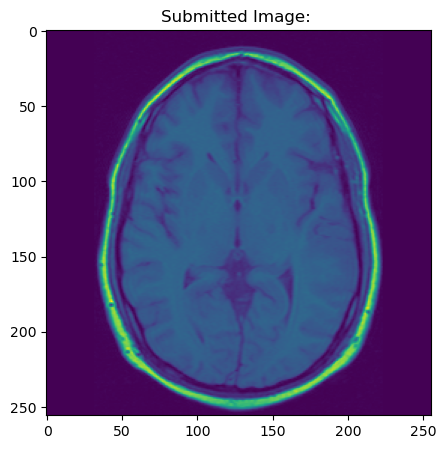

In [4]:
plt.figure(figsize=(5,5))
plt.title(f'Submitted Image: ')
plt.imshow(brainjson['inputs'][0]['data'][0])

<h4>Step 3: Request prediction from KServe InferenceService</h4>

In [5]:
url = str("http://") + str(ingress_host) + ":" + str(ingress_port) + "/v1/models/" + str(model_name) + ":predict"
headers = {'Host': service_hostname}
payload = json.dumps(brainjson)

In [6]:
response = requests.post(url, data=payload, headers=headers)
output = response.json()

shape = output["outputs"][0]["shape"]
values = output["outputs"][0]["data"]
output = torch.Tensor(np.array(values).reshape(shape))

<h4>Step 4: Analyze prediction (mask and overlay)</h4>

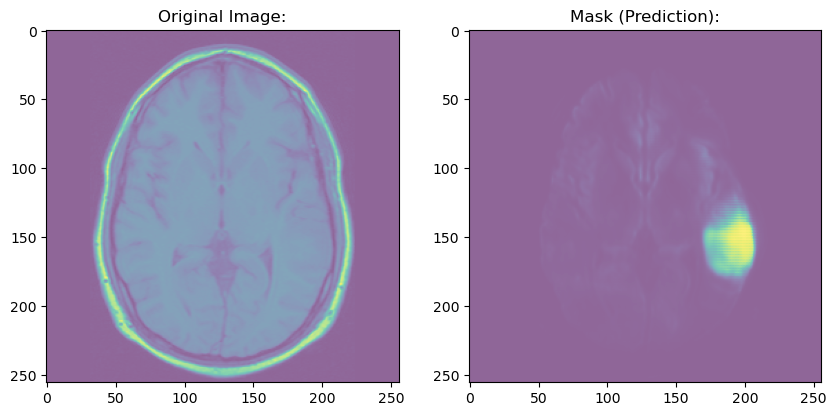

In [7]:
tensor_sample = brainjson['inputs'][0]['data'][0]
f, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(tensor_sample, alpha=0.6)
axarr[0].title.set_text(f'Original Image:')
axarr[1].imshow(output.permute(1, 2, 0), alpha=0.6)
axarr[1].title.set_text(f'Mask (Prediction):')

<h2>Part 2: Use this code to load images from a folder and generate predictions</h2>

In [ ]:
# Imports
import sys
import torch
import json
import uuid
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

<h4>Step 1: Setting up connection details to KServe and defining support functions</h4>

In [ ]:
# Define connection details for KServe InferenceService
model_name = "brain-mri"
ingress_host = "192.168.1.2"
ingress_port = "80"
service_hostname = "brain-mri-deploy.models.example.com"

In [ ]:
# Function to caluclate intersection over union of prediction
def iou(pred, label):
    intersection = (pred * label).sum()
    union = pred.sum() + label.sum() - intersection
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

# Function to create tensor for image and mask
def PairedToTensor(sample):
    img, mask = sample
    img = np.array(img)
    mask = np.expand_dims(mask, -1)
    img = np.moveaxis(img, -1, 0)
    mask = np.moveaxis(mask, -1, 0)
    img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
    img = img/255
    mask = mask/255
    return img, mask

<h4>Step 2: Prepare images for display and create JSON payload</h4>

In [ ]:
# Load image and mask
image = Image.open("./img/brain/TCGA_CS_6290_20000917_10.tif")
mask = Image.open("./img/brain/TCGA_CS_6290_20000917_10_mask.tif")

# Create tuple
sample = (image, mask)

# Create tensors from tuple
tensor_sample = PairedToTensor(sample)

# Create JSON payload for request
data = np.array(tensor_sample[0])
data_shape = list(data.shape)
request = {
    "inputs": [{
        "name": str(uuid.uuid4()),
        "shape": data_shape,
        "datatype": "FP32",
        "data": np.round(data, 4).tolist()
    }]
}

# Show image that will be submitted
plt.figure(figsize=(7,7))
plt.title(f'Submitted Image: ')
plt.imshow(tensor_sample[0].permute(1, 2, 0))

<h4>Step 3: Request prediction from KServe InferenceService</h4>

In [ ]:
# Create GRPC request for Prediction (header, URL, payload)
url = str("http://") + str(ingress_host) + ":" + str(ingress_port) + "/v1/models/" + str(model_name) + ":predict"
headers = {'Host': service_hostname}
payload = json.dumps(request)

In [ ]:
# Submit request, extract prediction in JSON, transform to Tensor
response = requests.post(url, data=payload, headers=headers)
output = response.json()

shape = output["outputs"][0]["shape"]
values = output["outputs"][0]["data"]
output = torch.Tensor(np.array(values).reshape(shape))

<h4>Step 4: Analyze prediction (mask and overlay)</h4>

In [ ]:
# Display groundtruth and prediction mask, call iou function and display iou
f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[0].title.set_text(f'Mask (Ground Truth):')
axarr[1].imshow(output.permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'Mask (Prediction):')
print(f'Intersection over Union (IoU): {iou(output, tensor_sample[1])}')

In [ ]:
# Display groundtruth and prediction overlaid on submitted image, call iou function and display iou
f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(tensor_sample[0].permute(1, 2, 0))
axarr[0].imshow(tensor_sample[1].permute(1, 2, 0), alpha=0.4)
axarr[0].title.set_text(f'Full Image (Ground Truth):')
axarr[1].imshow(tensor_sample[0].permute(1, 2, 0))
axarr[1].imshow(output.permute(1, 2, 0), alpha=0.4)
axarr[1].title.set_text(f'Full Image (Prediction):')
print(f'Intersection over Union (IoU): {iou(output, tensor_sample[1])}')